# Radar-adjustement for OpenMRG dataset

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../poligrain/src"))
sys.path.append(os.path.abspath("../mergeplg/src"))
sys.path.append(os.path.abspath("../pycomlink/"))


import poligrain as plg
import mergeplg as mrg
import pycomlink as pycml

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## 1. Load and explore the data

In [24]:
# Fetches 8 days from OpenMRG dataset
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

ds_cmls = ds_cmls.rename_vars({'R': 'R_example'}).load()
ds_rad = ds_rad.rename({'R':'rainfall_radar'})

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


In [25]:
# Project data to coordinate system
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, ref_str
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2


# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)

### Plot raw time series

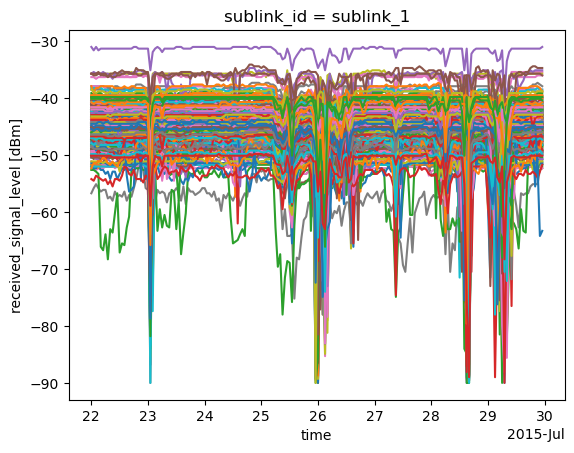

In [26]:
ds_cmls.rsl.isel(sublink_id=0).resample(time='1h').min().plot.line(x='time', add_legend=False);

Text(0.5, 1.0, 'Rain gauges')

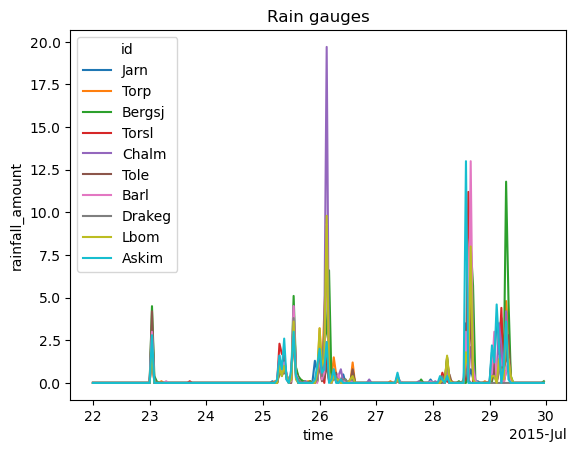

In [27]:
ds_gauges_municp.rainfall_amount.resample(time='1h').sum().plot.line(x='time');
plt.title('Rain gauges')

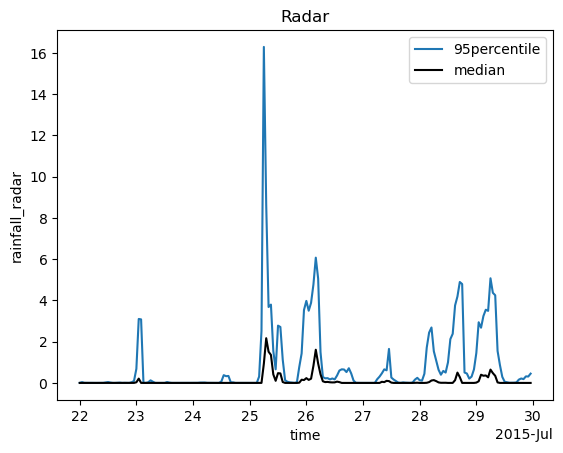

In [28]:
ds_rad.rainfall_radar.resample(time='1h').mean().quantile(q = 0.95, dim=['x', 'y']).plot(color = 'C0', label='95percentile');
ds_rad.rainfall_radar.resample(time='1h').mean().quantile(q = 0.5, dim=['x', 'y']).plot(color = 'k', label='median');
plt.title('Radar')
plt.legend()

### CML preprocessing 

In [29]:
# Select time window for preprocessing
start = ds_cmls.time[0]
end = ds_cmls.time[-1]
ds_cmls = ds_cmls.sel(time = slice(start, end)).load() # load() speeds up calculations

# Select sublink 0
ds_cmls = ds_cmls.isel(sublink_id = 0)

# Resample CML dataset to 1 minute resolution
ds_cmls = ds_cmls.resample(time = "1min").first(skipna=True)

# calculate total loss
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

# Interpolate na
ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

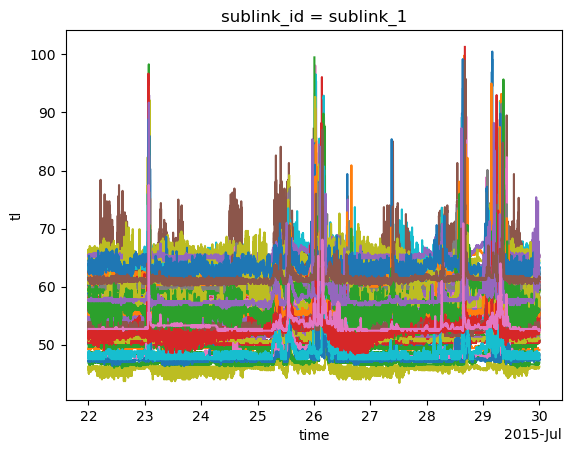

In [30]:
# flag cmls with strong diurnal fluctuation
qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 5, center=True).std() > 2).mean(dim="time") > 0.1
ds_cmls.where(qc_diurnalcicle, drop=True).tl.plot.line(x='time', add_legend=False);

# Remove flagged CMLs
ds_cmls = ds_cmls.where(~qc_diurnalcicle, drop=True)

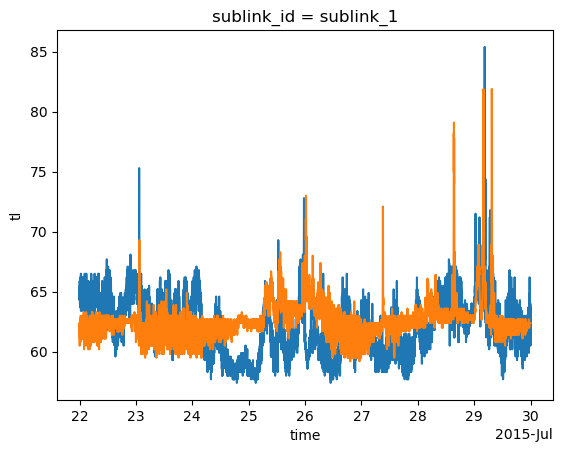

In [32]:
# flag cmls with very noisy periods
qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.20

# Plot noisy CMLs
ds_cmls.where(qc_noisyperiods, drop=True).tl.plot.line(x='time', add_legend=False);

# Remove flagged CMLs
ds_cmls = ds_cmls.where(~qc_noisyperiods, drop=True)

### CML processing using radar wet

In [33]:
# Estimate radar along CML
grid_at_lines = plg.spatial.GridAtLines(ds_rad, ds_cmls)

# Radar rainfall rates along CML
da_radar_along_cmls = grid_at_lines(ds_rad.rainfall_radar)

# Resample to sum 1 minute to make comparable to CML
ds_cmls['wet'] = (da_radar_along_cmls > 0.1).rolling(time=3, center=True).max()

In [34]:
# Estimate the baseline during rain events
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)

# compenmsate for wet antenna attenuation
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  # 0.55 is default
    d=0.15, # 
)


# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  # convert to km
    f_GHz=ds_cmls.frequency / 1000,  # convert to GHz
    pol=ds_cmls.polarization,
)

### Resample units of reference data to common 15 minute resolution

In [75]:
time_resample = '60min'
ds_rad_resampled = (ds_rad[['rainfall_radar']]*5/60).resample(time = time_resample, label='right', closed='right').sum() # from mm/h -> sum 5min
ds_gauges_resampled = ds_gauges_municp[['rainfall_amount']].resample(time=time_resample, label='right', closed='right').sum() # from sum 1min -> sum 15min 
ds_cmls_resampled = (ds_cmls[['R']]/60).resample(time = time_resample, label='right', closed='right').sum() # from mm/h -> sum 5min

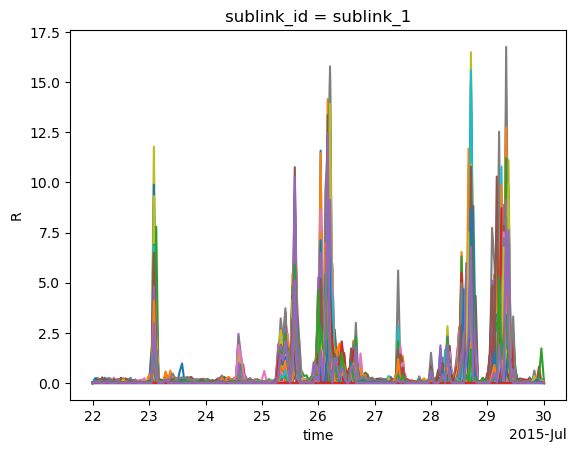

In [77]:
ds_cmls_resampled.R.plot.line(x='time', add_legend=False);

### Interpolate CMLs all time steps

In [79]:
# Import interpolator
interpolator = mrg.interpolate.InterpolateIDW()

# Interpolate several timesteps
rainfall_field = []
for time in ds_cmls_resampled.time.data:
    rainfall_field.append(
        interpolator.interpolate(
            da_grid = ds_rad_resampled.rainfall_radar.sel(time = [time]), 
            #da_gauge = da_gauge_smhi_15min.sel(time = [time]), 
            da_cml = ds_cmls_resampled.R.sel(time = [time]),
            p=2, # IDW parameter
            nnear=8, # IDW number of nearest observations to use
        )
    )

# Concat resulting fields
ds_rad_resampled['rainfall_interpolateIDW'] = xr.concat(rainfall_field, dim="time")

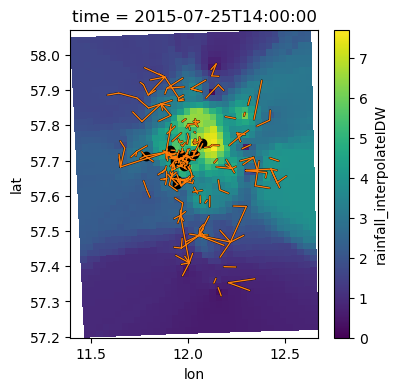

In [94]:
# Plot map
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plg.plot_map.plot_plg(
    da_grid=ds_rad_resampled['rainfall_interpolateIDW'].sel(time = '2015-07-25T14'),
    #da_gauges=da_gauges_municp_15min.isel(time = t),
    #da_cmls=da_cmls_15min.isel(time = 0),
    use_lon_lat=True,
    vmin=0,
    marker_size=100,
    cmap='viridis',
    ax=ax
)

# Plot CMLs
plg.plot_map.plot_lines(da_cmls_resampled.isel(time = 0), use_lon_lat=True, ax=ax, line_color= 'C1');

# PLot rain gauges
ax.scatter(da_gauges_resampled.lon, da_gauges_resampled.lat, color='k')

### Exercises
Create a kriging interpolated map showing the accumulated rainfall amounts for the rain gauges, the CMLs and the weather radar. 
1. For one time step
2. For all time steps
Hint: Use code from yesterday. Why is the maps different?


# 2. Evaluate rainfall maps at rain gauges
In this example we will study how well the radar and the CMLs predict the rain gauge observations

### Evaluate radar rainfall field at rain gauge

In [99]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_rad_resampled, 
    da_gauges_resampled, 
    nnear=1,
    stat="best",
)

ds_gauges_resampled['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad_resampled.rainfall_radar,
    da_point_data=ds_gauges_resampled.rainfall_amount,
)


### Plot time series of one rain gauge and weather radar

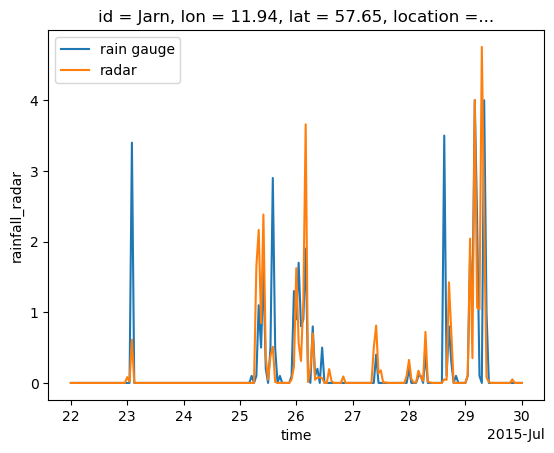

In [101]:
ds_gauges_resampled.rainfall_amount.isel(id = 0).plot(label='rain gauge')
ds_gauges_resampled.rainfall_radar.isel(id = 0).plot(label='radar')
plt.legend()

### Scatter-density plot radar VS rain gauge

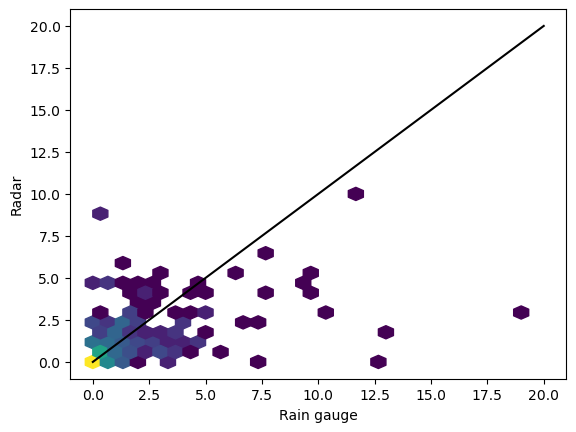

In [106]:
xmax = 20
plt.hexbin(
    ds_gauges_resampled.rainfall_amount,
    ds_gauges_resampled.rainfall_radar,
    bins='log',
    gridsize=30,
    extent = [0, xmax, 0, xmax],
)
plt.plot([0, xmax], [0, xmax], 'k');
plt.xlabel('Rain gauge');
plt.ylabel('Radar');

### Exercises
1. Evaluate CML IDW interpolated field at rain gauges
2. Evaluate CML Kriging interpolated field at rain gauges

# 3. Merge CML and radar data for 8 days

In [3]:
import sys
import os
sys.path.append(os.path.abspath("../poligrain/src"))
sys.path.append(os.path.abspath("../mergeplg/src"))
sys.path.append(os.path.abspath("../pycomlink/"))


import poligrain as plg
import mergeplg as mrg
import pycomlink as pycml
import tqdm

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Fetches 8 days from OpenMRG dataset
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

ds_cmls = ds_cmls.rename_vars({'R': 'R_example'}).load()
ds_rad = ds_rad.rename({'R':'rainfall_radar'})

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


### Project coordinates

In [5]:
# Project data to coordinate system
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, ref_str
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2


# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)

### Pre-process CML data

In [6]:
# Select time window for preprocessing
start = ds_cmls.time[0]
end = ds_cmls.time[-1]
ds_cmls = ds_cmls.sel(time = slice(start, end)).load() # load() speeds up calculations

# Select sublink 0
ds_cmls = ds_cmls.isel(sublink_id = 0)

# Resample CML dataset to 1 minute resolution
ds_cmls = ds_cmls.resample(time = "1min").first(skipna=True)

# calculate total loss
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

# Interpolate na
ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# flag cmls with strong diurnal fluctuation
qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 5, center=True).std() > 2).mean(dim="time") > 0.1

# Remove flagged CMLs
ds_cmls = ds_cmls.where(~qc_diurnalcicle, drop=True)

# flag cmls with very noisy periods
qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.20

# Remove flagged CMLs
ds_cmls = ds_cmls.where(~qc_noisyperiods, drop=True)

### Process CML data

In [7]:
# Estimate radar along CML
grid_at_lines = plg.spatial.GridAtLines(ds_rad, ds_cmls)

# Radar rainfall rates along CML
da_radar_along_cmls = grid_at_lines(ds_rad.rainfall_radar)

# Resample to sum 1 minute to make comparable to CML
ds_cmls['wet'] = (da_radar_along_cmls > 0.1).rolling(time=3, center=True).max()

# Estimate the baseline during rain events
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)

# compenmsate for wet antenna attenuation
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  # 0.55 is default
    d=0.15, # 
)


# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  # convert to km
    f_GHz=ds_cmls.frequency / 1000,  # convert to GHz
    pol=ds_cmls.polarization,
)

### Resample data to common time resolution

In [8]:
time_resample = '60min'
ds_rad_resampled = (ds_rad[['rainfall_radar']]*5/60).resample(time = time_resample, label='right', closed='right').sum() # from mm/h -> sum 5min
ds_gauges_resampled = ds_gauges_municp[['rainfall_amount']].resample(time=time_resample, label='right', closed='right').sum() # from sum 1min -> sum 15min 
ds_cmls_resampled = (ds_cmls[['R']]/60).resample(time = time_resample, label='right', closed='right').sum() # from mm/h -> sum 5min

### Merge IDW and kriging for all time steps

In [12]:
# Import interpolator
merger = mrg.merge.MergeDifferenceIDW(min_observations=2)

# Interpolate several timesteps
rainfall_field = []
for time in ds_cmls_resampled.time.data:
    rainfall_field.append(
        merger.adjust(
            da_rad = ds_rad_resampled.rainfall_radar.sel(time = [time]), 
            #da_gauge = da_gauge_smhi_15min.sel(time = [time]), 
            da_cml = ds_cmls_resampled.R.sel(time = [time]),
            p=7, # IDW parameter
            nnear=7, # IDW number of nearest observations to use
        )
    )

# Concat resulting fields
ds_rad_resampled['rainfall_adjustIDW'] = xr.concat(rainfall_field, dim="time")

In [18]:
get_grid_at_points = plg.spatial.GridAtPoints(
    ds_rad_resampled, 
    ds_gauges_resampled, 
    nnear=1,
    stat="best",
)

ds_gauges_resampled['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad_resampled.rainfall_radar,
    da_point_data=ds_gauges_resampled.rainfall_amount,
)

ds_gauges_resampled['rainfall_adjustIDW'] = get_grid_at_points(
    da_gridded_data=ds_rad_resampled.rainfall_adjustIDW,
    da_point_data=ds_gauges_resampled.rainfall_amount,
)

### Exercises

Plot hexbin and metrics for 
1. Radar vs rain gauge (Hint: Code below)
2. Adjusted CML-radar using IDW vs rain gauges
3. Adjusted CML-radar using Ordinary kriging vs rain gauges (Hint: See code below for kriging)

Text(0.95, 0.55, 'pearson r: 0.53\nrmse: 1.55 mm/h\nbias: -10.58%\nN points: 1930\nN nans: 0')

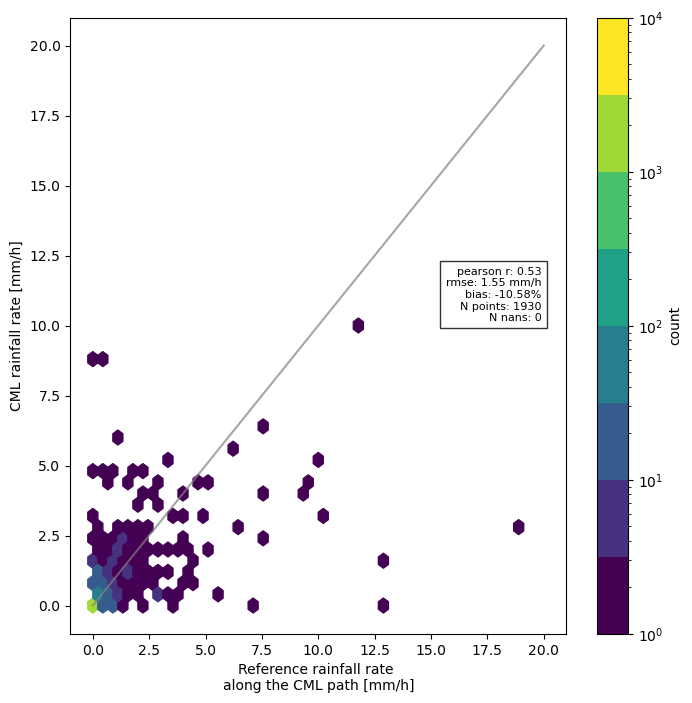

In [30]:
xmax = 20
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
reference = ds_gauges_resampled.rainfall_amount.data.ravel()
estimate = ds_gauges_resampled.rainfall_radar.data.ravel()

# Plot hexbin
plg.validation.plot_hexbin(reference, estimate, ax=ax)

threshold = 0.01 # values below are ignored
rainfall_metrics = plg.validation.calculate_rainfall_metrics(
    reference=reference,
    estimate=estimate,
    ref_thresh=threshold,
    est_thresh=threshold,
)
plotted_metrics = (
    f"pearson r: {np.round(rainfall_metrics['pearson_correlation_coefficient'], 2)}\n"
    f"rmse: {np.round(rainfall_metrics['root_mean_square_error'], 2)} mm/h\n"
    f"bias: {np.round(rainfall_metrics['percent_bias'], 2)}%\n"
    f"N points: {rainfall_metrics['N_all']}\n"
    f"N nans: {rainfall_metrics['N_nan']}"
)

ax.text(
    0.95,
    0.55,
    plotted_metrics,
    fontsize=8,
    transform=ax.transAxes,
    verticalalignment="center",
    horizontalalignment="right",
    bbox={"facecolor": "white", "alpha": 0.8},
)


In [31]:
# Import interpolator
merger = mrg.merge.MergeDifferenceOrdinaryKriging(min_observations=1)

# Interpolate several timesteps
rainfall_field = []
for time in tqdm.tqdm(ds_cmls_resampled.time.data):
    rainfall_field.append(
        merger.adjust(
            da_rad = ds_rad_resampled.rainfall_radar.sel(time = [time]), 
            #da_gauge = da_gauge_smhi_15min.sel(time = [time]), 
            da_cml = ds_cmls_resampled.R.sel(time = [time]),
            variogram_model = "spherical",
            variogram_parameters = {"sill": 1, "range": 8000, "nugget": 0.2},
            nnear=7,
            full_line=False, # Use midpoint of the CML
        )
    )

# Concat resulting fields
ds_rad_resampled['rainfall_adjustOBK'] = xr.concat(rainfall_field, dim="time")


100%|███████████████████████████████████████████████████████████████████| 193/193 [01:20<00:00,  2.39it/s]


# Extra exercises
1. Plot 